### Prepare Data



#### imports and setup:

So rodar estes dois pip's se nao tiver ainda feito:

In [1]:
#pip install roboflow

In [2]:
#pip install imagehash

In [ ]:
#pip install albumentations

In [100]:
#import libraries:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil
import glob
import io
import os
import pathlib
import PIL
from PIL import Image
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import yaml
import random
import pandas as pd
import hashlib
from collections import Counter, defaultdict
from pathlib import Path
from roboflow import Roboflow
import imagehash
from sklearn.model_selection import train_test_split
import albumentations as A
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
import cv2, torch
from torch.utils.data import Dataset, DataLoader

from tensorflow.keras import Model, optimizers, callbacks
from tensorflow.keras.applications import ResNet50


Import Dataset:

Este dataset, downloaded em formato YOLOv8
contém imagens e TXT annotations and YAML config onde se encontram as respetivas labels e label id.

YOLOv8 is a state-of-the-art object detection and image segmentation model


 https://universe.roboflow.com/car-damage-detection-cardd/car-damage-severity-detection-cardd

In [ ]:
#from roboflow with yolov8
#if already have the dataset, no need to run this:
rf = Roboflow(api_key="YHTjnmxe3lRU4B3THhhe")
project = rf.workspace("car-damage-detection-cardd").project("car-damage-severity-detection-cardd")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Car-Damage-Severity-Detection/CarDD-3 in yolov8:: 100%|██████████| 4012/4012 [00:02<00:00, 1337.56it/s]


In [3]:
#paths and dir:
BASE_path = Path("./Car-Damage-Severity-Detection/CarDD-3")
BASE_dir = "./Car-Damage-Severity-Detection/CarDD-3"

train_path = pathlib.Path("./Car-Damage-Severity-Detection/CarDD-3/train")
train_labels_dir = "./Car-Damage-Severity-Detection/CarDD-3/train/labels"

valid_path = pathlib.Path("./Car-Damage-Severity-Detection/CarDD-3/valid")
valid_labels_dir = "./Car-Damage-Severity-Detection/CarDD-3/valid/labels"

test_path = pathlib.Path("./Car-Damage-Severity-Detection/CarDD-3/test")
test_labels_dir = "./Car-Damage-Severity-Detection/CarDD-3/test/labels"

---
#### Data Content:

DEsta vez, como cada imagem pode ter mais do que uma label, em vez das classes estarem em pastas, estao todas no ficheiro yaml

Para saber quantas imagens e labels tem cada set (train, valid, test):


In [4]:
print("Conteúdo de CarDD-3:", os.listdir(BASE_dir))

for sub in os.listdir(BASE_dir):
    subpath = os.path.join(BASE_dir, sub)
    if os.path.isdir(subpath):
        print(f" - {sub}:", os.listdir(subpath))

print("\n")

#Contagem de imagens e labels:
for split in ["train", "valid", "test"]:
  img_dir = os.path.join(BASE_dir, split, "images")
  lbl_dir = os.path.join(BASE_dir, split, "labels")

  n_images = len([f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")])
  n_labels = len([f for f in os.listdir(lbl_dir) if f.lower().endswith(".txt")])

  print(f"{split:5s}: {n_images:4d} imagens, {n_labels:4d} labels")

Conteúdo de CarDD-3: ['data.yaml', 'data_merged.yaml', 'labels_merged', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']
 - labels_merged: ['test', 'train', 'valid']
 - test: ['images', 'labels']
 - train: ['images', 'labels']
 - valid: ['images', 'labels']


train: 1395 imagens, 1395 labels
valid:  401 imagens,  401 labels
test :  204 imagens,  204 labels


In [5]:
#quantas labels ha:
class_ids = set()
for fname in os.listdir(train_labels_dir):
    if not fname.endswith('.txt'): continue
    with open(os.path.join(train_labels_dir, fname)) as f:
        for line in f:
            cid = int(line.split()[0])
            class_ids.add(cid)

print('IDs de classes:', sorted(class_ids))
print(f'Total de classes: {len(class_ids)}')

IDs de classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Total de classes: 11


Há 11 classes. nas imagens tem os id's e o yaml indica qual o correspondente nome


In [6]:
with open('./Car-Damage-Severity-Detection/CarDD-3/data.yaml') as f:
    data = yaml.safe_load(f)

print("Nomes de classe (ID --> nome):")
for idx, name in enumerate(data['names']):
    print(idx, name)

Nomes de classe (ID --> nome):
0 car-part-crack
1 detachment
2 flat-tire
3 glass-crack
4 lamp-crack
5 minor-deformation
6 moderate-deformation
7 paint-chips
8 scratches
9 severe-deformation
10 side-mirror-crack


---
#### Vizualise the dataset:

In [7]:
#labels
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    data = yaml.safe_load(f)
class_names = data["names"]




*   train set





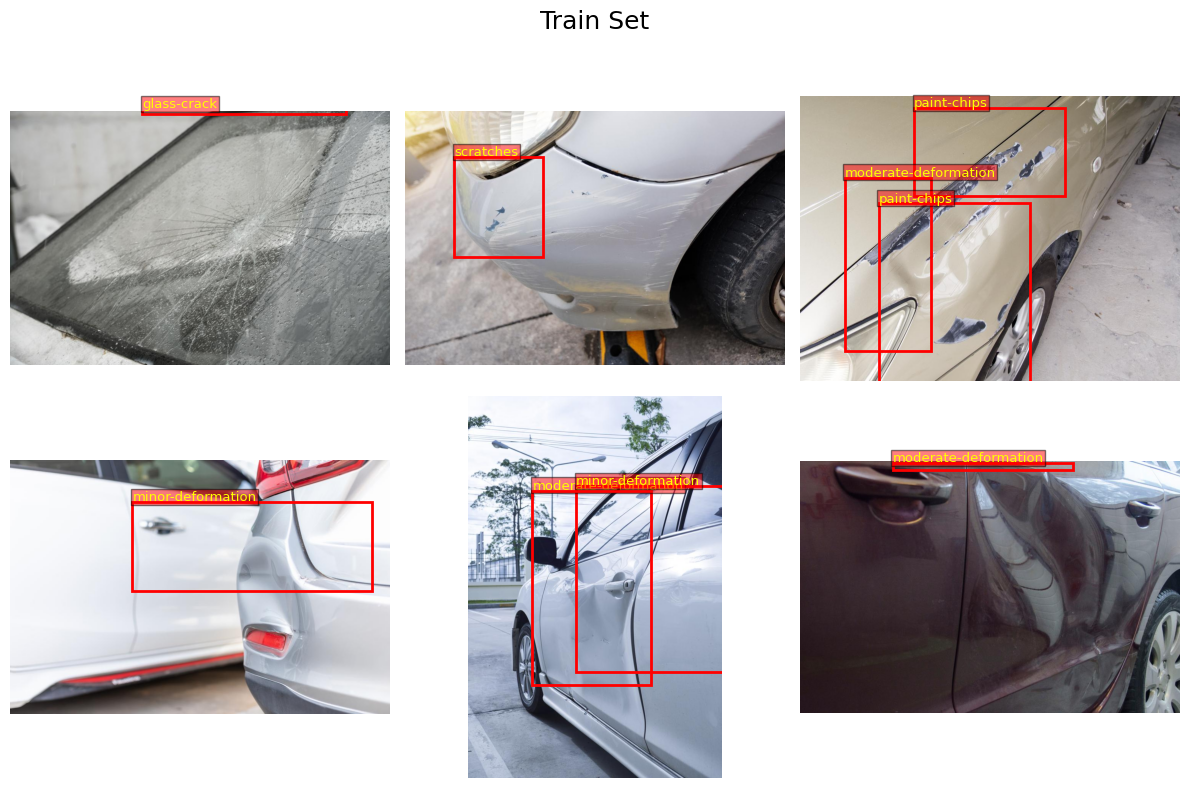

In [8]:
#ver o train set
split = "train"
img_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
lbl_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"


imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
sample = random.sample(imgs, 6)
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Train Set", fontsize=18)
#fig.subplots_adjust(top=0.3)
for i, fname in enumerate(sample, 1):
    img = Image.open(os.path.join(img_dir, fname))
    w, h = img.size

    boxes = []
    with open(os.path.join(lbl_dir, fname.replace(".jpg", ".txt"))) as f_lbl:
        for line in f_lbl:
            vals = line.split()
            cid = int(vals[0])
            x_center, y_center, bw, bh = map(float, vals[1:5])
            x1 = (x_center - bw/2) * w
            y1 = (y_center - bh/2) * h
            boxes.append((cid, x1, y1, bw*w, bh*h))

    ax = fig.add_subplot(2, 3, i)
    ax.imshow(img); ax.axis("off")

    for cid, x1, y1, bw_px, bh_px in boxes:
        rect = patches.Rectangle((x1, y1), bw_px, bh_px,
                                 linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1-5, class_names[cid],
                fontsize=9.5, color="yellow",
                bbox=dict(facecolor="red", alpha=0.5, pad=1))

#plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()



*   validation set


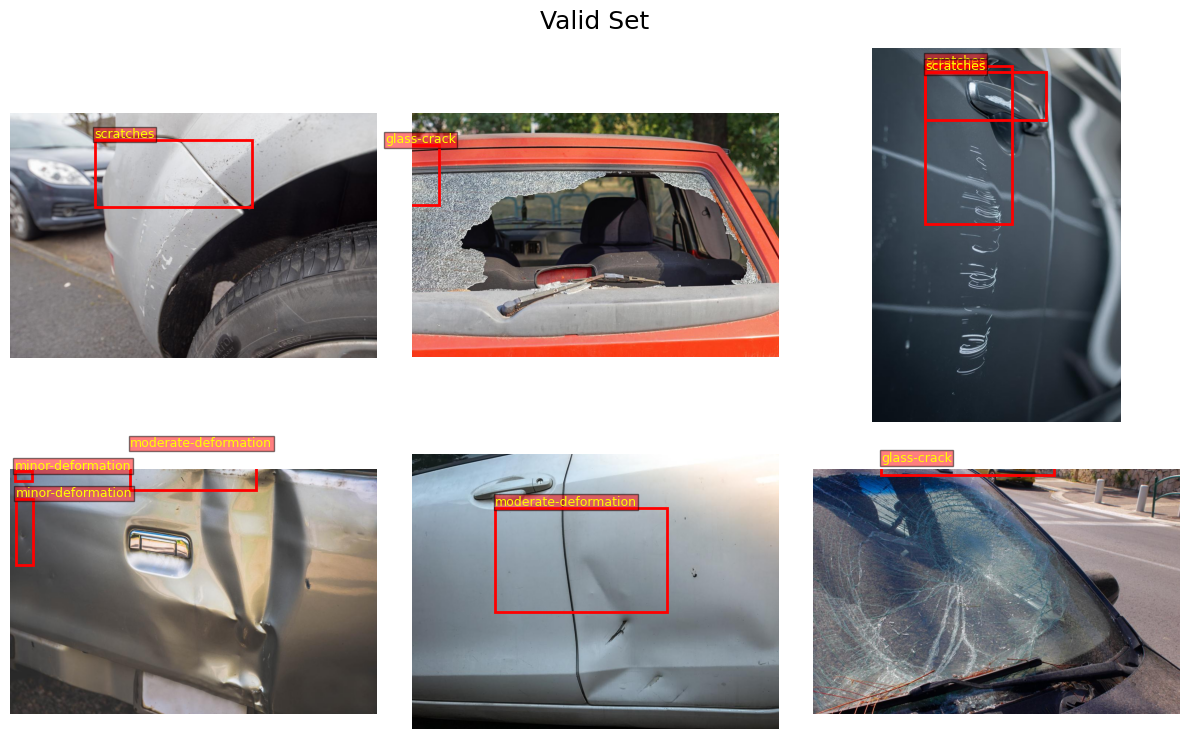

In [9]:
#ver o valid set
split = "valid"
img_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
lbl_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"


imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
sample = random.sample(imgs, 6)
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Valid Set", fontsize=18)
#fig.subplots_adjust(top=0.3)
for i, fname in enumerate(sample, 1):
    img = Image.open(os.path.join(img_dir, fname))
    w, h = img.size

    boxes = []
    with open(os.path.join(lbl_dir, fname.replace(".jpg", ".txt"))) as f_lbl:
        for line in f_lbl:
            vals = line.split()
            cid = int(vals[0])
            x_center, y_center, bw, bh = map(float, vals[1:5])
            x1 = (x_center - bw/2) * w
            y1 = (y_center - bh/2) * h
            boxes.append((cid, x1, y1, bw*w, bh*h))

    ax = fig.add_subplot(2, 3, i)
    ax.imshow(img); ax.axis("off")

    for cid, x1, y1, bw_px, bh_px in boxes:
        rect = patches.Rectangle((x1, y1), bw_px, bh_px,
                                 linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1-5, class_names[cid],
                fontsize=9, color="yellow",
                bbox=dict(facecolor="red", alpha=0.5, pad=1))

plt.tight_layout()
#plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

---
#### Sanity-checks:

* Leakage:

In [9]:
TRAIN_GLOB = "./Car-Damage-Severity-Detection/CarDD-3/train/**/*.jpg"
VAL_GLOB   = "./Car-Damage-Severity-Detection/CarDD-3/valid/**/*.jpg"
PHASH_THRESH = 5

def sha1(path: str) -> str:
  with open(path, "rb") as f:
    return hashlib.sha1(f.read()).hexdigest()
def phash(path: str) -> imagehash.ImageHash:
  return imagehash.phash(Image.open(path))

def find_duplicates(train_glob: str, val_glob: str, phash_thresh: int = 5):
  train_paths = glob.glob(train_glob, recursive=True)
  val_paths   = glob.glob(val_glob, recursive=True)
  print(f"→ TRAIN imgs: {len(train_paths)}")
  print(f"→  VAL  imgs: {len(val_paths)}")

  train_sha = {sha1(p): p for p in train_paths}
  val_sha   = {sha1(p): p for p in val_paths}
  exact = [(train_sha[h], val_sha[h]) for h in train_sha if h in val_sha]
  print(f"Duplicados EXACTOS: {len(exact)}")
  for a, b in exact[:3]:
    print("  •", a, "\n   ", b)

  val_ph = {phash(p): p for p in val_paths}
  close = []
  for p in train_paths:
    h = phash(p)
    for hv in val_ph:
      if h - hv <= phash_thresh:
        close.append((p, val_ph[hv]))
  print(f"Duplicados PARECIDOS (≤{phash_thresh} bits): {len(close)}")
  for a, b in close[:3]:
    print("  •", a, "\n   ", b)

  return exact, close

if __name__ == "__main__":
    leaks_exact, leaks_close = find_duplicates(TRAIN_GLOB, VAL_GLOB, PHASH_THRESH)
    if leaks_exact or leaks_close:
        print("\n⚠️ Detetado leakage")
    else:
        print("\n✅ Sem leakage.")


→ TRAIN imgs: 1395
→  VAL  imgs: 401
Duplicados EXACTOS: 0
Duplicados PARECIDOS (≤5 bits): 0

✅ Sem leakage.


* Data corruption:

In [10]:
splits = ["train", "valid", "test"]

def find_corrupted(split):
  corrupted = []
  img_dir = BASE_path / split / "images"
  for img_path in img_dir.glob("*.jpg"):
    try:
      with Image.open(img_path) as img:
        img.verify()
    except (UnidentifiedImageError, OSError) as e:
      corrupted.append((img_path.name, str(e)))
  return corrupted

#to know if there is any image corrupted for each split:
for split in splits:
    bad = find_corrupted(split)
    if not bad:
        print(f"{split:5s}: nenhuma imagem corrompida encontrada ✅")
    else:
        print(f"{split:5s}: {len(bad)} imagens corrompidas ❌")
        for name, err in bad:
            print(f"   • {name:<40s} → {err}")

train: nenhuma imagem corrompida encontrada ✅
valid: nenhuma imagem corrompida encontrada ✅
test : nenhuma imagem corrompida encontrada ✅


* Label balance

In [11]:
with open(BASE_path / "data.yaml") as f:
    class_names = yaml.safe_load(f)["names"]

rows = []
for split in ["train", "valid", "test"]:
    counts = {name: 0 for name in class_names}
    for lbl_file in (BASE_path / split / "labels").glob("*.txt"):
        for line in open(lbl_file):
            parts = line.split()
            if parts:
                cid = int(parts[0])
                counts[class_names[cid]] += 1
    rows.append({"split": split, **counts})

df_counts = pd.DataFrame(rows)
df_counts

,split,car-part-crack,detachment,flat-tire,glass-crack,lamp-crack,minor-deformation,moderate-deformation,paint-chips,scratches,severe-deformation,side-mirror-crack
0,train,348,54,119,253,249,246,630,266,991,48,8
1,valid,73,10,33,70,70,74,174,72,313,13,4
2,test,50,4,15,35,34,26,86,31,157,8,2


Há 2 classes, detatchment e side mirror crack que têm =< 10 count no valid set. 

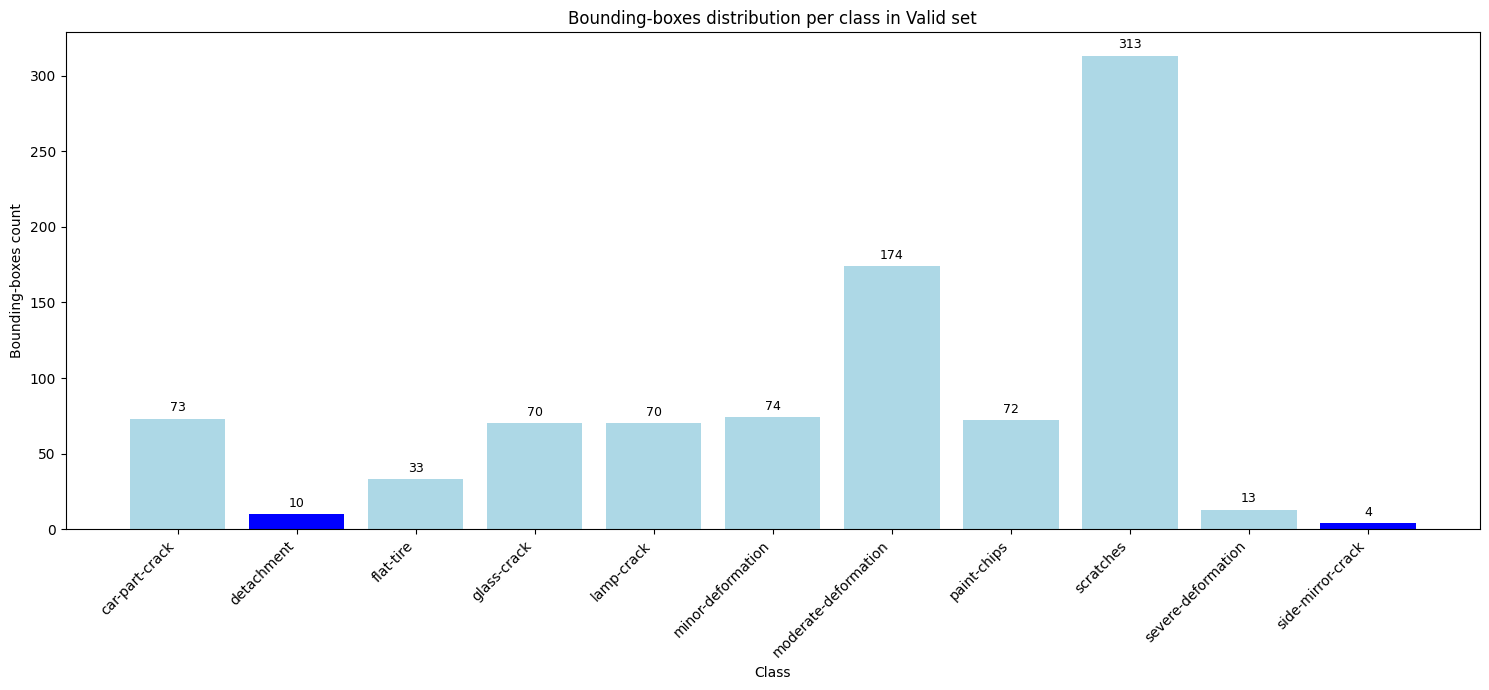

In [12]:
class_names = df_counts.columns.drop("split").tolist()
vals = df_counts.loc[df_counts["split"]=="valid", class_names].values.flatten()

x = np.arange(len(class_names))
plt.figure(figsize=(15, 7))

colors = ['blue' if v <= 10 else 'lightblue' for v in vals]
bars = plt.bar(x, vals, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  
        yval + 3,                          
        f"{int(yval)}",                  
        ha="center", va="bottom", fontsize=9
    )

plt.xlabel("Class")
plt.ylabel("Bounding-boxes count")
plt.title("Bounding-boxes distribution per class in Valid set")
plt.xticks(x, class_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()

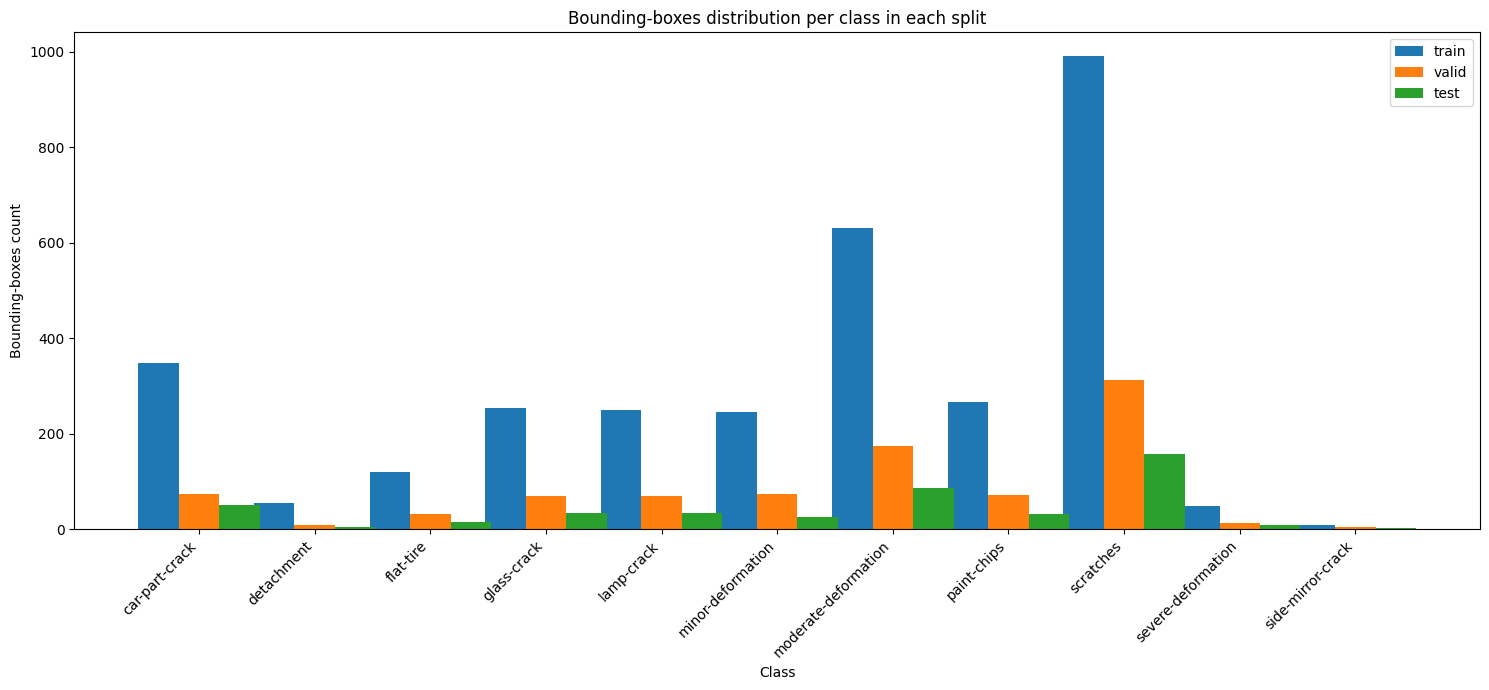

In [13]:
#ver todas as classes:
class_names = df_counts.columns.drop("split").tolist()
splits = df_counts["split"].tolist()
values = [ df_counts.loc[i, class_names].values for i in range(len(splits)) ]

x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(15,7))
for i, (split, vals) in enumerate(zip(splits, values)):
    plt.bar(x + i*width, vals, width, label=split)

plt.xlabel("Class")
plt.ylabel("Bounding-boxes count")
plt.title("Bounding-boxes distribution per class in each split")
plt.xticks(x + width, class_names, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

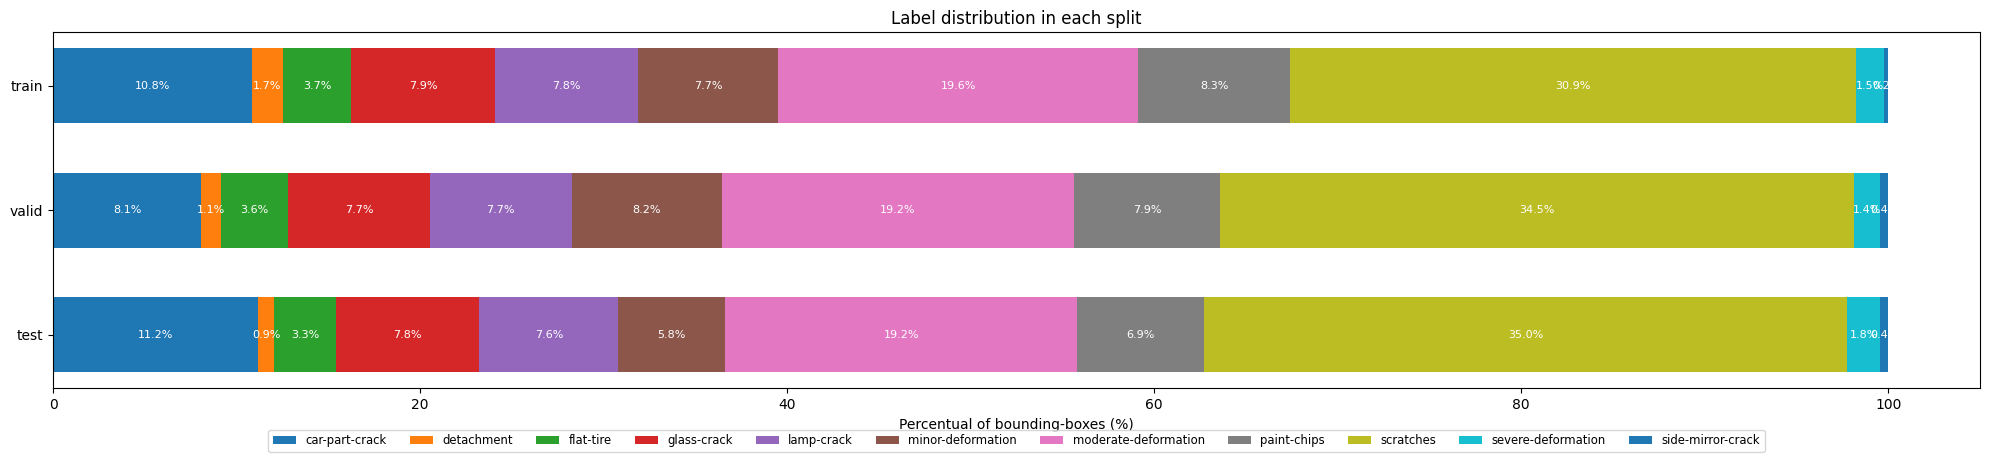

In [14]:
df_pct = df_counts.set_index("split")
df_pct = df_pct.div(df_pct.sum(axis=1), axis=0) * 100

splits  = df_pct.index.tolist() 
classes = df_pct.columns.tolist()
y = np.arange(len(splits))

fig, ax = plt.subplots(figsize=(20, 5))

left = np.zeros(len(splits))
for cls in classes:
    widths = df_pct[cls].values
    bars = ax.barh(y, widths, left=left, height=0.6, label=cls)
    for bar, w in zip(bars, widths):
        if w < 0.2:  # pula segmentos muito pequenos
            continue
        x_text = bar.get_x() + w/2
        y_text = bar.get_y() + bar.get_height()/2
        ax.text(
            x_text, y_text, f"{w:.1f}%",
            ha="center", va="center",
            color="white", fontsize=8
        )
    left += widths

ax.set_yticks(y)
ax.set_yticklabels(splits)
ax.set_xlabel("Percentual of bounding-boxes (%)")
ax.set_title("Label distribution in each split")
ax.invert_yaxis()

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=11,
    fontsize="small"
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

Como algumas classes mostram um desbalanceamento entre as classes, talvez seja melhor dar merge a algumas.

---
### Models:

#### Previous model - Prepair data:

In [10]:
#lista de labels para o train set:
records = []
for img in (BASE_path/"train"/"images").glob("*.jpg"):
    lbl = (BASE_path/"train"/"labels"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) #nomes das labels
    #records.append({"filepath": str(img), "label": cid }) #label id (so o numero)

df_train = pd.DataFrame(records)
print(df_train)

                                               filepath                 label
0     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
1     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
2     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
3     Car-Damage-Severity-Detection\CarDD-3\train\im...     minor-deformation
4     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
...                                                 ...                   ...
1383  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1384  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1385  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1386  Car-Damage-Severity-Detection\CarDD-3\train\im...             scratches
1387  Car-Damage-Severity-Detection\CarDD-3\train\im...  moderate-deformation

[1388 rows x 2 columns]


In [11]:
#lista de labels para o valid set:
records = []
for img in (BASE_path/"valid"/"images").glob("*.jpg"):
    lbl = (BASE_path/"valid"/"labels"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) #nomes das labels
    #records.append({"filepath": str(img), "label": cid }) #label id (so o numero)

df_valid = pd.DataFrame(records)
print(df_valid)

                                              filepath                 label
0    Car-Damage-Severity-Detection\CarDD-3\valid\im...           paint-chips
1    Car-Damage-Severity-Detection\CarDD-3\valid\im...             scratches
2    Car-Damage-Severity-Detection\CarDD-3\valid\im...             scratches
3    Car-Damage-Severity-Detection\CarDD-3\valid\im...     minor-deformation
4    Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
..                                                 ...                   ...
396  Car-Damage-Severity-Detection\CarDD-3\valid\im...           glass-crack
397  Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
398  Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
399  Car-Damage-Severity-Detection\CarDD-3\valid\im...     minor-deformation
400  Car-Damage-Severity-Detection\CarDD-3\valid\im...    severe-deformation

[401 rows x 2 columns]


In [12]:

#map string para int
class_to_idx = { name: idx for idx, name in enumerate(class_names) }

df_train['label_id'] = df_train['label'].map(class_to_idx)
df_valid['label_id'] = df_valid['label'].map(class_to_idx)
df_valid['label_id']

0      7
1      8
2      8
3      5
4      6
      ..
396    3
397    6
398    6
399    5
400    9
Name: label_id, Length: 401, dtype: int64

In [13]:
#extrair arrays
filepaths = df_train['filepath'].to_numpy()
labels = df_train['label_id'].to_numpy().astype(np.int32)

filepaths_val = df_valid['filepath'].to_numpy()
labels_val = df_valid['label_id'].to_numpy().astype(np.int32)

img_height = 180
img_width  = 180
batch_size = 32

NUM_CLASSES = len(class_names)

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0
    return img, label

ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds_val = tf.data.Dataset.from_tensor_slices((filepaths_val, labels_val))

* `Dataset.cache` keeps the images in memory after they are loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model.
* `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [14]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (ds
    .shuffle(len(filepaths))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (ds_val
    .shuffle(len(filepaths_val))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

#### Previous model - Compile and Train the model

Train the model for 15, 50 and 100 epochs with the Keras `Model.fit` method:

In [15]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_height, 3)),
    layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax', name="outputs")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,059 (15.22 MB)

 Trainable params: 3,990,059 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

* 15 epochs

In [96]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.2595 - loss: 2.0365 - val_accuracy: 0.2943 - val_loss: 1.8421
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3080 - loss: 1.8434 - val_accuracy: 0.2943 - val_loss: 1.8248
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.3080 - loss: 1.8368 - val_accuracy: 0.2943 - val_loss: 1.8205
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3080 - loss: 1.8346 - val_accuracy: 0.2943 - val_loss: 1.8155
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.3080 - loss: 1.8299 - val_accuracy: 0.2943 - val_loss: 1.8076
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.3065 - loss: 1.8094 - val_accuracy: 0.3217 - val_loss: 1.7766
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3082 - loss: 1.7583 - val_accuracy: 0.3317 - val_loss: 1.7441
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3507 - loss: 1.7105 - val_accuracy: 0.3092 - v

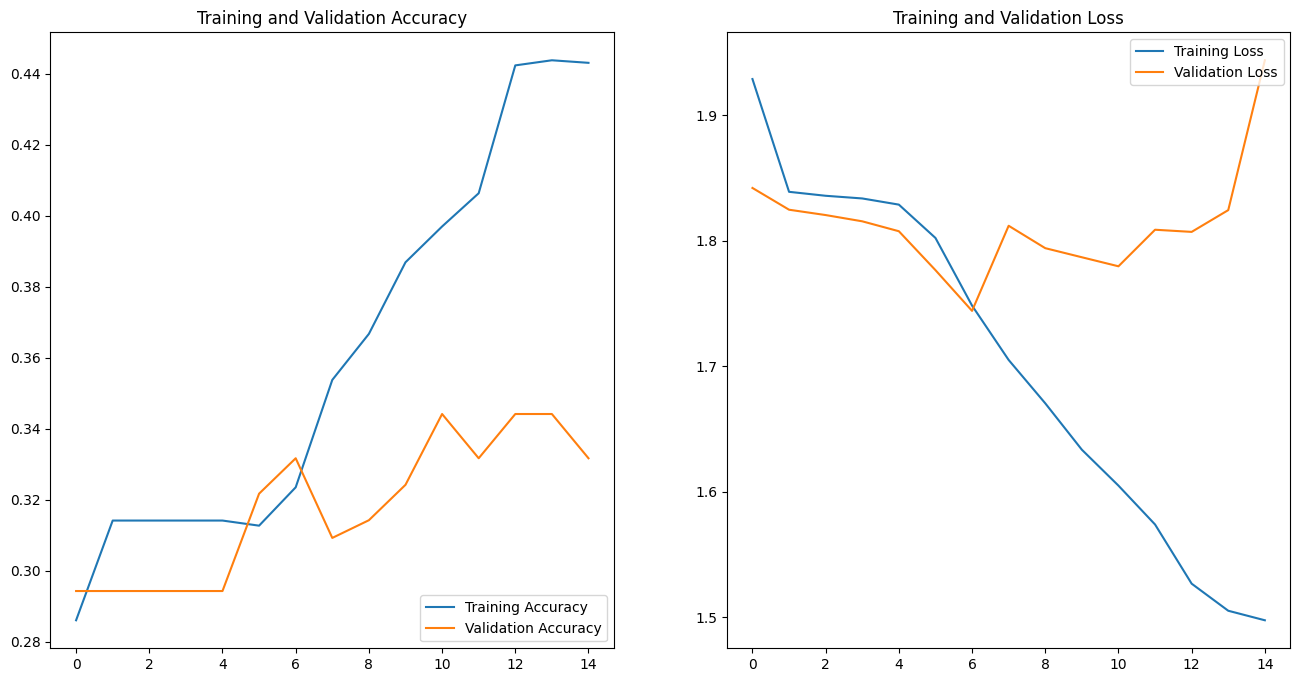

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* 50 epochs

In [ ]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_height, 3)),
    layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax', name="outputs")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

In [89]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.2581 - loss: 2.0662 - val_accuracy: 0.2943 - val_loss: 1.8335
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.3080 - loss: 1.8422 - val_accuracy: 0.2943 - val_loss: 1.8224
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.3080 - loss: 1.8360 - val_accuracy: 0.2943 - val_loss: 1.8195
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3080 - loss: 1.8348 - val_accuracy: 0.2943 - val_loss: 1.8166
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3080 - loss: 1.8321 - val_accuracy: 0.2943 - val_loss: 1.8129
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.3066 - loss: 1.8215 - val_accuracy: 0.2918 - val_loss: 1.7911
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.3105 - loss: 1.7803 - val_accuracy: 0.3117 - val_loss: 1.7540
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.3160 - loss: 1.7283 - val_accuracy: 0.3217 - v

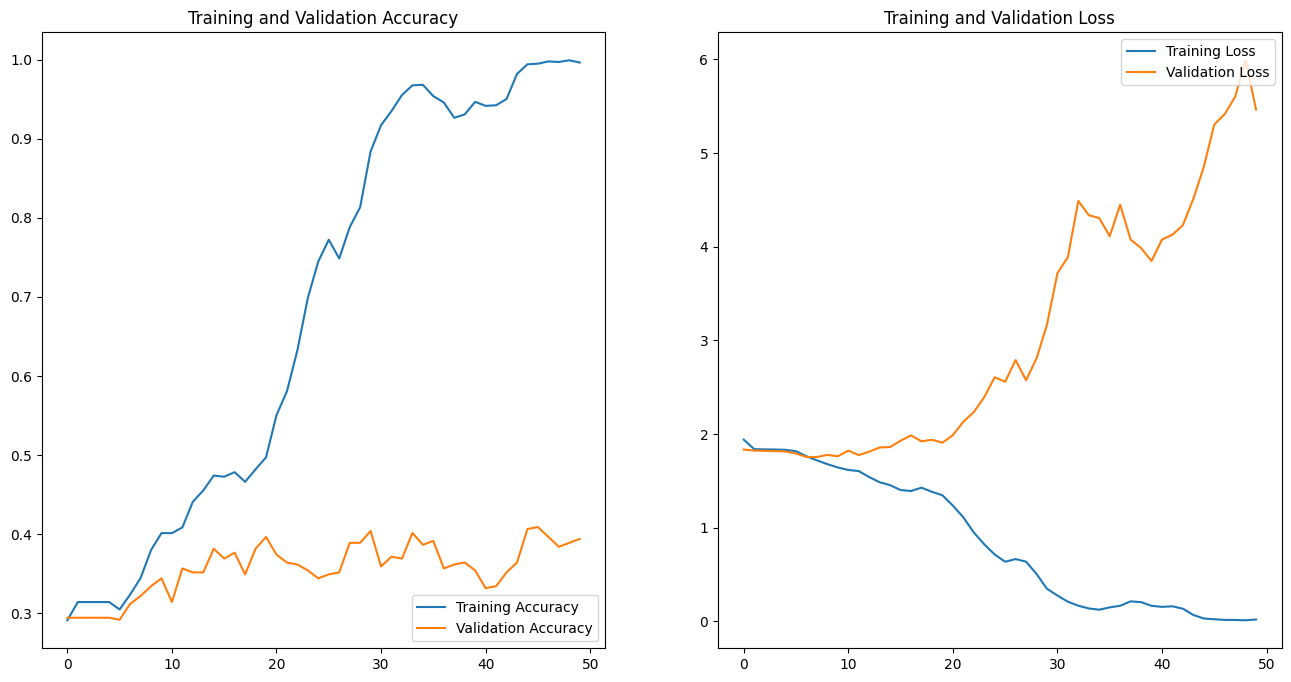

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* 100 epochs:

In [ ]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_height, 3)),
    layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax', name="outputs")
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

In [92]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.2537 - loss: 2.0569 - val_accuracy: 0.2943 - val_loss: 1.8422
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.3039 - loss: 1.8414 - val_accuracy: 0.2943 - val_loss: 1.8292
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3080 - loss: 1.8369 - val_accuracy: 0.2943 - val_loss: 1.8254
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3080 - loss: 1.8351 - val_accuracy: 0.2943 - val_loss: 1.8216
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3080 - loss: 1.8325 - val_accuracy: 0.2943 - val_loss: 1.8174
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.3081 - loss: 1.8271 - val_accuracy: 0.2943 - val_loss: 1.8081
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.3093 - loss: 1.8056 - val_accuracy: 0.2893 - val_loss: 1.7920
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.3155 - loss: 1.7680 - val_accuracy: 0.

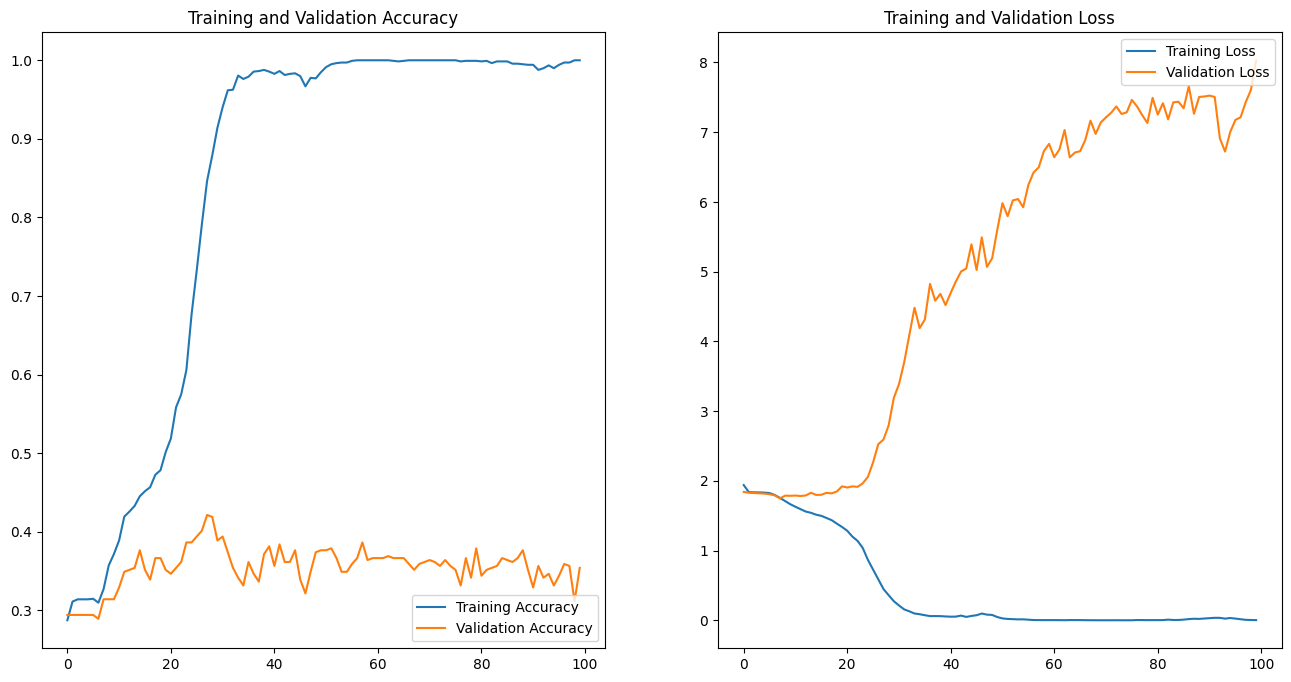

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

---
#### New model - Prepair data

##### Convert labels to csv

Converter ficheiros .txt em vector multi-label: \
ResNet só precisa de saber “esta imagem contém classe 0, 5 e 8”.

Le cada .txt, recolhe os class_id distintos e guarda num CSV.

Multi-hot (0/1) serve quando queres apenas “esta classe aparece ou não”.
Mas, para uma estimativa de custo, o número de instâncias por classe
(2 arranhões vs 1) :


*   Colunas h0…h10 → hot (0/1) — bom para o classificador.

* Colunas n0…n10 → counts — podes usar como features extra no regress
LightGBM (ou outro modelo de custo).



In [16]:
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    CLASSES = yaml.safe_load(f)["names"]
NUM_CLASSES = len(CLASSES)

print(NUM_CLASSES, CLASSES)

11 ['car-part-crack', 'detachment', 'flat-tire', 'glass-crack', 'lamp-crack', 'minor-deformation', 'moderate-deformation', 'paint-chips', 'scratches', 'severe-deformation', 'side-mirror-crack']


In [17]:
def labels_to_counts(label_path: str, num_classes: int):
    counts = [0] * num_classes
    with open(label_path) as f:
        for line in f:
            cid = int(line.split()[0])
            counts[cid] += 1
    return counts

def build_csv(split: str):
    IMG_DIR   = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
    LABEL_DIR = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"

    rows = []
    for lp in glob.glob(f"{LABEL_DIR}/*.txt"):
        img_name = os.path.basename(lp).replace(".txt", ".jpg")  # muda p/ .png se for o caso
        counts   = labels_to_counts(lp, NUM_CLASSES)
        hot      = [1 if n > 0 else 0 for n in counts]

        row = {"image": f"{IMG_DIR}/{img_name}"}
        row.update({f"h{i}": v for i, v in enumerate(hot)})    # presença
        row.update({f"n{i}": v for i, v in enumerate(counts)}) # nº instâncias
        rows.append(row)

    df = pd.DataFrame(rows)
    csv_out = f"{split}_multilabel.csv"
    df.to_csv(csv_out, index=False)
    print(f"Gravado {csv_out} com {len(df)} linhas")
    return df.head()

In [18]:
for split in ["train", "valid", "test"]:
    head = build_csv(split)
    if split == "train":
        print("\nPreview do train\n", head)

Gravado train_multilabel.csv com 1395 linhas

Preview do train
                                                image  h0  h1  h2  h3  h4  h5  \
0  ./Car-Damage-Severity-Detection/CarDD-3/train/...   1   0   1   0   0   0   
1  ./Car-Damage-Severity-Detection/CarDD-3/train/...   0   0   1   0   0   0   
2  ./Car-Damage-Severity-Detection/CarDD-3/train/...   0   0   1   0   0   0   
3  ./Car-Damage-Severity-Detection/CarDD-3/train/...   0   0   1   0   0   1   
4  ./Car-Damage-Severity-Detection/CarDD-3/train/...   0   0   1   0   0   0   

   h6  h7  h8  ...  n1  n2  n3  n4  n5  n6  n7  n8  n9  n10  
0   0   0   0  ...   0   1   0   0   0   0   0   0   0    0  
1   0   0   0  ...   0   1   0   0   0   0   0   0   0    0  
2   0   0   0  ...   0   1   0   0   0   0   0   0   0    0  
3   0   0   1  ...   0   2   0   0   1   0   0   1   0    0  
4   1   1   0  ...   0   1   0   0   0   1   1   0   0    0  

[5 rows x 23 columns]
Gravado valid_multilabel.csv com 401 linhas
Gravado test_mul

---
##### Transformations


transformações: \
- Augmentations - Aumentar a variedade do treino (menos over-fit) e
- redimensionamento - deixa as imagens no formato que a ResNet espera (640×640)

para para **imagens train set**
1. RandomResizedCrop – recorta 80-100 % da imagem e redimensiona para 640×640 → simula zooms/enquadramentos diferentes.
2. HorizontalFlip – espelha metade das vezes → dobra o dataset virtualmente.
3. Rotate (±15°) – tolera fotos um pouco inclinadas.
4. RandomBrightnessContrast – variação de luz.
5. GaussNoise – ruído de câmara/compressão.
6. Normalize – converte 0-255→ (float32) e aplica média/STD do ImageNet (necessário para redes pré-treinadas).
7. ToTensorV2 – converte numpy → tensor PyTorch C×H×W.-

E para **imagens valid set** apenas redimensiona para 640×640, normaliza e converte em tensor. Mantemos as imagens “puras” para medir o desempenho real.

In [19]:
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    class_names = yaml.safe_load(f)["names"]
NUM_CLASSES = len(class_names)

IMG_SIZE = 640

In [20]:
#augmentation às imagens de treino:
train_tfms = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), ratio=(3/4,4/3), p=1.0),
    #A.RandomResizedCrop(height=IMG_SIZE, width=IMG_SIZE, scale=(0.8, 1.0), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

#e para valid set:
val_tfms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

---

#### New model - implement

pip install ultralytics


!yolo detect train \
  model=yolov8s.pt \
  data=Car-Damage-Severity-Detection/CarDD-3/data.yaml \
  epochs=50 \
  imgsz=640 \
  batch=16
For YOLOv8: yolo detect train \
data=data.yaml \
model=yolov8n.pt \
imgsz=640 \
epochs=50 \
lr0=0.01 \
frozen=10.

!yolo detect train \
  data=./Car-Damage-Severity-Detection/CarDD-3/data.yaml \
  model=yolov8s.pt \
  epochs=30 \
  project=runs/train \
  name=car_damage_v1

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')
model.train(
    data='./Car-Damage-Severity-Detection/CarDD-3/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    project='runs/train',
    name='car_damage_v1'
)

---


#### Data imbalance:


As classes que tinham poucos samples eram a "detachment" e "side-miror-crack", podemos ver uns exemplos:

In [37]:
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    data = yaml.safe_load(f)
class_names = data["names"]
target_class = "side-mirror-crack"
#target_class = "detachment"
target_cid   = class_names.index(target_class)

split   = "train"
img_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
lbl_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"

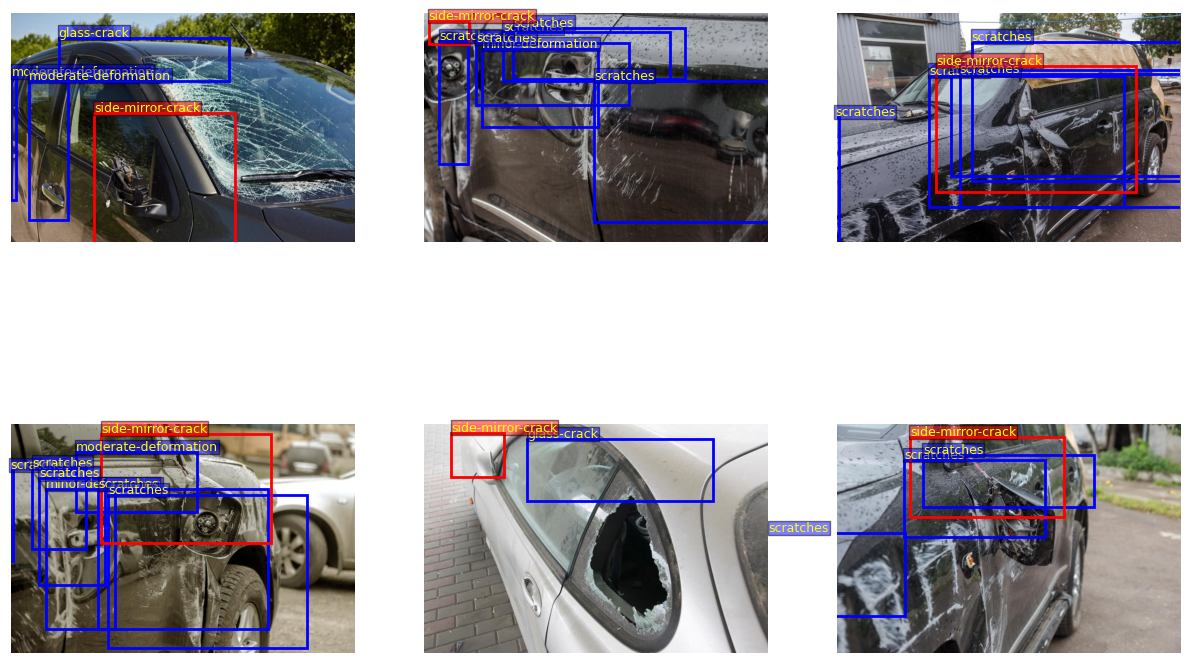

In [38]:
all_imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
det_imgs = []
for img_name in all_imgs:
    lbl_path = os.path.join(lbl_dir, img_name.replace(".jpg", ".txt"))
    with open(lbl_path) as f_lbl:
        for line in f_lbl:
            cid = int(line.split()[0])
            if cid == target_cid:
                det_imgs.append(img_name)
                break

sample = random.sample(det_imgs, min(len(det_imgs), 6))

fig = plt.figure(figsize=(12, 10))
for i, fname in enumerate(sample, 1):
    img = Image.open(os.path.join(img_dir, fname))
    w, h = img.size
    boxes = []
    with open(os.path.join(lbl_dir, fname.replace(".jpg", ".txt"))) as f_lbl:
        for line in f_lbl:
            parts = line.split()
            cid = int(parts[0])
            x_c, y_c, bw, bh = map(float, parts[1:5])
            x1 = (x_c - bw/2) * w
            y1 = (y_c - bh/2) * h
            boxes.append((cid, x1, y1, bw * w, bh * h))

    ax = fig.add_subplot(2, 3, i)
    ax.imshow(img)
    ax.axis("off")

    for cid, x1, y1, bw_px, bh_px in boxes:
        color = "red" if cid == target_cid else "blue"
        rect = patches.Rectangle((x1, y1), bw_px, bh_px,
                                 linewidth=2, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, class_names[cid],
                fontsize=9, color="yellow",
                bbox=dict(facecolor=color, alpha=0.5, pad=0.5))

plt.tight_layout()
plt.show()

In [39]:
orig_yaml = BASE_path/"data.yaml"
merged_yaml = BASE_path/"data_merged.yaml"

with open(orig_yaml) as f:
    data = yaml.safe_load(f)
orig_names = data["names"]

merge_map = {
    "side-mirror-crack" : "car-part-crack",
    "detachment"  : "severe-deformation",
}

new_names = []
for name in orig_names:
    target = merge_map.get(name, name)
    if target not in new_names:
        new_names.append(target)

old2new = { old_i: new_names.index( merge_map.get(old_name, old_name) )
            for old_i, old_name in enumerate(orig_names) }

data["names"] = new_names
data["nc"]    = len(new_names)
# ajusta os paths:
data["train"] = str(Path(data["train"]).parent / "train/images")
data["val"]   = str(Path(data["val"]).parent   / "valid/images")
data["test"]  = str(Path(data["test"]).parent  / "test/images")

with open(merged_yaml, "w") as f:
    yaml.dump(data, f, sort_keys=False)
print(f"{merged_yaml} com classes: {new_names}")

Car-Damage-Severity-Detection\CarDD-3\data_merged.yaml com classes: ['car-part-crack', 'severe-deformation', 'flat-tire', 'glass-crack', 'lamp-crack', 'minor-deformation', 'moderate-deformation', 'paint-chips', 'scratches']


In [40]:
for split in ["train", "valid", "test"]:
    src_lbl_dir = BASE_path/split/"labels"
    dst_lbl_dir = BASE_path/"labels_merged"/split
    dst_lbl_dir.mkdir(parents=True, exist_ok=True)

    for txt in sorted((src_lbl_dir).glob("*.txt")):
        lines = txt.read_text().splitlines()
        new_lines = []
        for line in lines:
            parts = line.split()
            if len(parts) < 5:
                continue
            old_id = int(parts[0])
            coords = parts[1:]
            new_id = old2new.get(old_id)
            if new_id is None:
                continue
            new_lines.append(" ".join([str(new_id)] + coords))
        (dst_lbl_dir/ txt.name).write_text("\n".join(new_lines))

    print(f"  • {split:5s}: reescritos {len(list(dst_lbl_dir.glob('*.txt')))} labels em labels_merged/{split}")


  • train: reescritos 1395 labels em labels_merged/train
  • valid: reescritos 401 labels em labels_merged/valid
  • test : reescritos 204 labels em labels_merged/test


Para ver como ficou o merged, perceber a distribuiçao dos labels:

In [41]:
with open(BASE_path / "data_merged.yaml") as f:
    class_names = yaml.safe_load(f)["names"]

rows = []
for split in ["train", "valid", "test"]:
    counts = {name: 0 for name in class_names}
    for lbl_file in (BASE_path /"labels_merged"/ split).glob("*.txt"):
        for line in open(lbl_file):
            parts = line.split()
            if parts:
                cid = int(parts[0])
                counts[class_names[cid]] += 1
    rows.append({"split": split, **counts})

df_counts = pd.DataFrame(rows)
df_counts

,split,car-part-crack,severe-deformation,flat-tire,glass-crack,lamp-crack,minor-deformation,moderate-deformation,paint-chips,scratches
0,train,356,102,119,253,249,246,630,266,991
1,valid,77,23,33,70,70,74,174,72,313
2,test,52,12,15,35,34,26,86,31,157


In [42]:
with open('./Car-Damage-Severity-Detection/CarDD-3/data_merged.yaml') as f:
    data = yaml.safe_load(f)

print("Nomes de classe (ID --> nome):")
for idx, name in enumerate(data['names']):
    print(idx, name)

Nomes de classe (ID --> nome):
0 car-part-crack
1 severe-deformation
2 flat-tire
3 glass-crack
4 lamp-crack
5 minor-deformation
6 moderate-deformation
7 paint-chips
8 scratches


#### Re-try model:

In [43]:
#lista de labels para o train set:
records = []
for img in (BASE_path/"train"/"images").glob("*.jpg"):
    lbl = (BASE_path/"labels_merged"/"train"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) 
df_train = pd.DataFrame(records)

df_train

,filepath,label
0,Car-Damage-Severity-Detection\CarDD-3\train\im...,flat-tire
1,Car-Damage-Severity-Detection\CarDD-3\train\im...,flat-tire
2,Car-Damage-Severity-Detection\CarDD-3\train\im...,flat-tire
3,Car-Damage-Severity-Detection\CarDD-3\train\im...,minor-deformation
4,Car-Damage-Severity-Detection\CarDD-3\train\im...,flat-tire
...,...,...
1383,Car-Damage-Severity-Detection\CarDD-3\train\im...,glass-crack
1384,Car-Damage-Severity-Detection\CarDD-3\train\im...,glass-crack
1385,Car-Damage-Severity-Detection\CarDD-3\train\im...,glass-crack
1386,Car-Damage-Severity-Detection\CarDD-3\train\im...,scratches


In [44]:
#lista de labels para o valid set:
records = []
for img in (BASE_path/"valid"/"images").glob("*.jpg"):
    lbl = (BASE_path/"labels_merged"/"valid"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) #nomes das labels
    #records.append({"filepath": str(img), "label": cid }) #label id (so o numero)
df_valid = pd.DataFrame(records)
df_valid

,filepath,label
0,Car-Damage-Severity-Detection\CarDD-3\valid\im...,paint-chips
1,Car-Damage-Severity-Detection\CarDD-3\valid\im...,scratches
2,Car-Damage-Severity-Detection\CarDD-3\valid\im...,scratches
3,Car-Damage-Severity-Detection\CarDD-3\valid\im...,minor-deformation
4,Car-Damage-Severity-Detection\CarDD-3\valid\im...,moderate-deformation
...,...,...
396,Car-Damage-Severity-Detection\CarDD-3\valid\im...,glass-crack
397,Car-Damage-Severity-Detection\CarDD-3\valid\im...,moderate-deformation
398,Car-Damage-Severity-Detection\CarDD-3\valid\im...,moderate-deformation
399,Car-Damage-Severity-Detection\CarDD-3\valid\im...,minor-deformation


In [45]:
#map string para int
class_to_idx = { name: idx for idx, name in enumerate(class_names) }

df_train['label_id'] = df_train['label'].map(class_to_idx)
df_valid['label_id'] = df_valid['label'].map(class_to_idx)

#extrair arrays
filepaths = df_train['filepath'].to_numpy()
labels = df_train['label_id'].to_numpy().astype(np.int32)

filepaths_val = df_valid['filepath'].to_numpy()
labels_val = df_valid['label_id'].to_numpy().astype(np.int32)

img_height = 224
img_width  = 224
batch_size = 32

NUM_CLASSES = len(class_names)
NUM_CLASSES

9

In [46]:
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0
    return img, label

ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds_val = tf.data.Dataset.from_tensor_slices((filepaths_val, labels_val))
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (ds
    .shuffle(len(filepaths))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (ds_val
    .shuffle(len(filepaths_val))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [47]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_height, 3)),
    layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax', name="outputs")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,401 (24.59 MB)

 Trainable params: 6,447,401 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.2450 - loss: 1.9594 - val_accuracy: 0.2943 - val_loss: 1.8203
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.3156 - loss: 1.8356 - val_accuracy: 0.2943 - val_loss: 1.8104
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.3162 - loss: 1.8355 - val_accuracy: 0.2943 - val_loss: 1.8099
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.3163 - loss: 1.8352 - val_accuracy: 0.2943 - val_loss: 1.8097
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.3162 - loss: 1.8348 - val_accuracy: 0.2943 - val_loss: 1.8099
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.3162 - loss: 1.8330 - val_accuracy: 0.2943 - val_loss: 1.8071
Epoch 7/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.3161 - loss: 1.8267 - val_accuracy: 0.3142 - val_loss: 1.7887
Epoch 8/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.3185 - loss: 1.7941 - val_accuracy: 0.

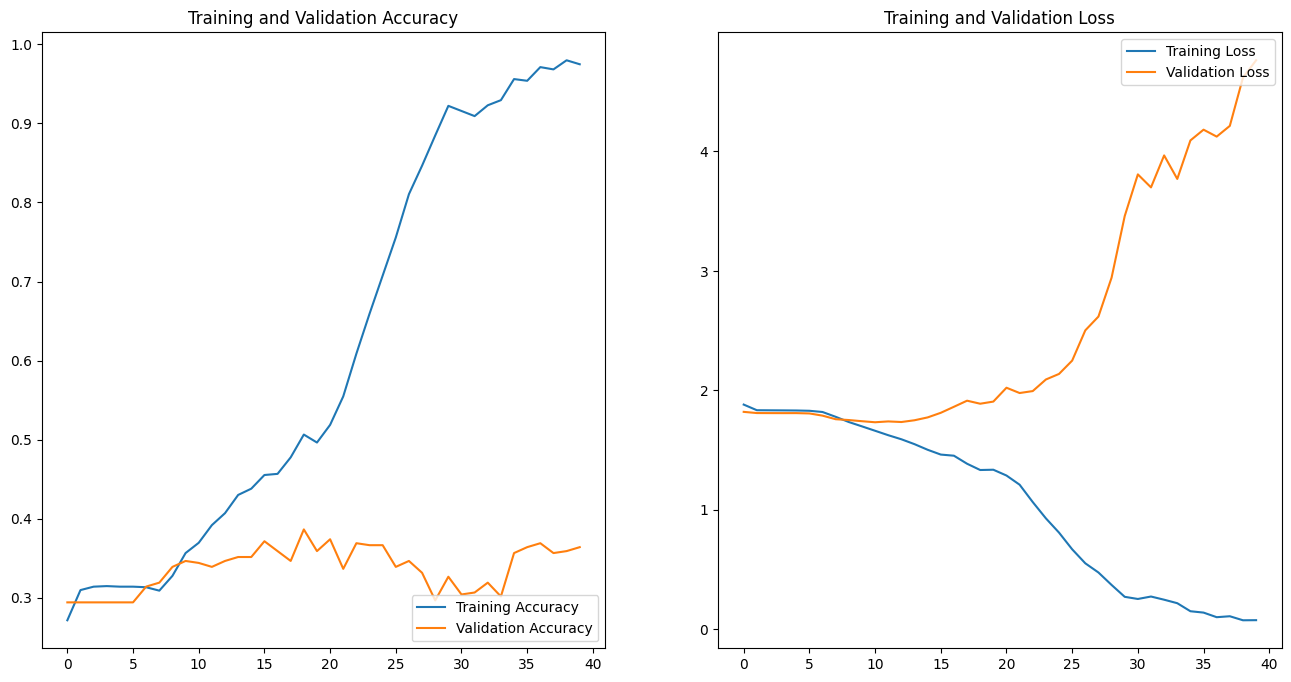

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



---
#### New model:

In [61]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks
from tensorflow.keras.applications import ResNet50

# 1) Hyper-params
IMG_SIZE    = 224    # or whatever you resized to
NUM_CLASSES = len(class_names)
LR          = 1e-3
EPOCHS      = 15

In [62]:


# 2) Load the ResNet50 backbone
backbone = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

In [63]:


# 3) Freeze only the first two stages: conv1 and conv2_x
#    By convention ResNet50 layers are named 'conv1_*' and 'conv2_block*_out'
for layer in backbone.layers:
    if layer.name.startswith("conv1_") or layer.name.startswith("conv2_"):
        layer.trainable = False
    else:
        layer.trainable = True

# 4) Build your new head on top
x = backbone.output
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(0.3, name="dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="predictions")(x)

model = Model(backbone.input, outputs, name="resnet50_frozen2stages")




In [ ]:
# 5) Compile with a high LR for the head
model.compile(
    optimizer=optimizers.Adam(learning_rate=LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()  # inspect that conv1 & conv2 layers are indeed non-trainable



In [65]:
# 6) (Optional) callbacks
es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
mc = callbacks.ModelCheckpoint("resnet50_stage2_head.h5", save_best_only=True)

# 7) Train for 10 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    #callbacks=[es, mc]
)

Epoch 1/15


44/44 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3244 - loss: 2.1046 - val_accuracy: 0.2718 - val_loss: 18.1635
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.4507 - loss: 1.5883 - val_accuracy: 0.1297 - val_loss: 14.4120
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4736 - loss: 1.4350 - val_accuracy: 0.2993 - val_loss: 1.9168
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5514 - loss: 1.3176 - val_accuracy: 0.2768 - val_loss: 2.2232
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.6008 - loss: 1.0953 - val_accuracy: 0.1721 - val_loss: 6.1525
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6240 - loss: 1.0806 - val_accuracy: 0.1297 - val_loss: 3.4133
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.6530 - loss: 0.9473 - val_accuracy: 0.2170 - val_loss: 3.1205
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6790 - loss: 0.8903 - val_accuracy: 0.2993 - val_loss: 

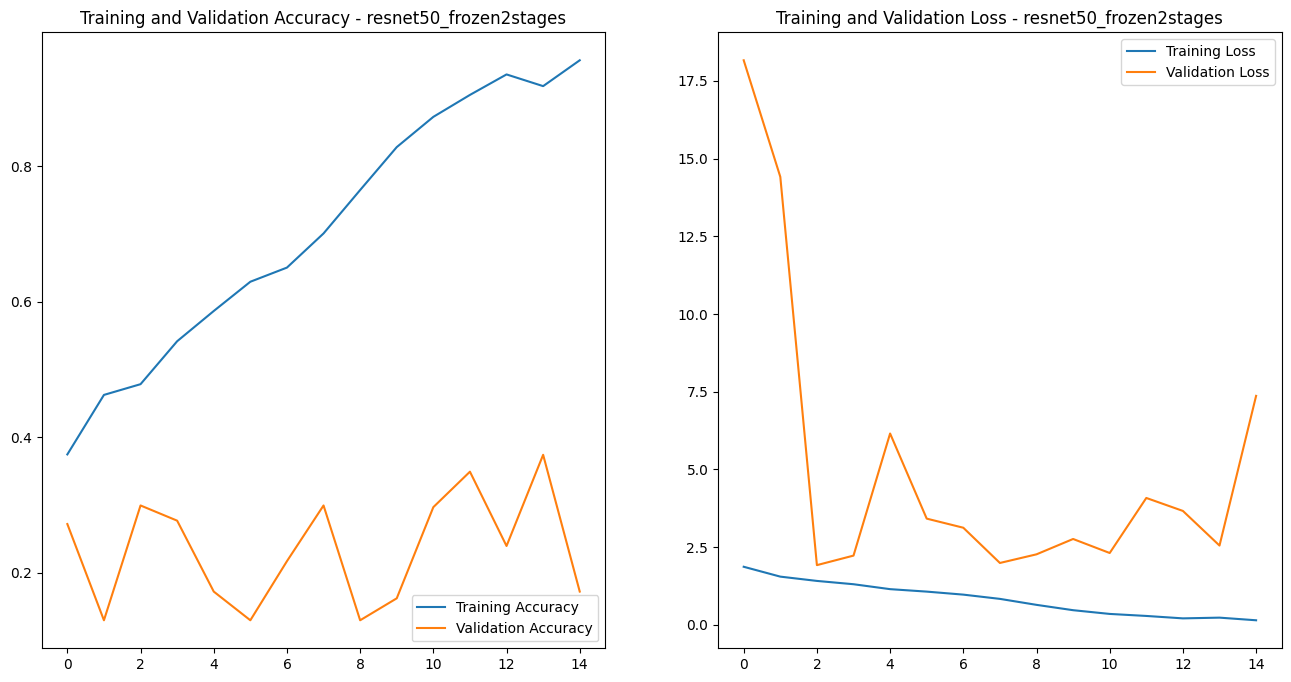

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - resnet50_frozen2stages')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - resnet50_frozen2stages')
plt.show()

In [ ]:
model = Model(backbone.input, outputs, name="resnet50_frozen2stages")


In [95]:
model = models.Sequential()


In [ ]:
model.add(layers.UpSampling2D((7, 7)))


In [ ]:
model.add(backbone)

In [96]:
model.add(base_model)

In [97]:
# 5) Compile with a high LR for the head
model.compile(
    optimizer=optimizers.Adam(learning_rate=LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary() 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(
            train_ds,
            epochs=5, 
            batch_size=20, 
            validation_data=val_ds
      )

In [107]:


# 1) Hyper-params
IMG_SIZE    = 224    # or whatever you resized to
NUM_CLASSES = len(class_names)
LR          = 1e-3
EPOCHS      = 10

# 2) Load the ResNet50 backbone
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
#base_model.summary()
model = models.Sequential()
#model.add(layers.UpSampling2D((7, 7)))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
# Add A Output Layer
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))




model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['acc']
)

model.summary()



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,606,153 (90.05 MB)

 Trainable params: 23,553,033 (89.85 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [108]:
with tf.device('/device:GPU:0'):
      history = model.fit(
            train_ds,
            epochs=5, 
            batch_size=20, 
            validation_data=val_ds
      )

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - acc: 0.4640 - loss: 1.6780 - val_acc: 0.2793 - val_loss: 3.1141
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - acc: 0.9694 - loss: 0.1837 - val_acc: 0.2793 - val_loss: 3.9105
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - acc: 1.0000 - loss: 0.0156 - val_acc: 0.2943 - val_loss: 4.4753
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - acc: 1.0000 - loss: 0.0025 - val_acc: 0.1895 - val_loss: 4.7833
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - acc: 1.0000 - loss: 0.0012 - val_acc: 0.1372 - val_loss: 5.0904


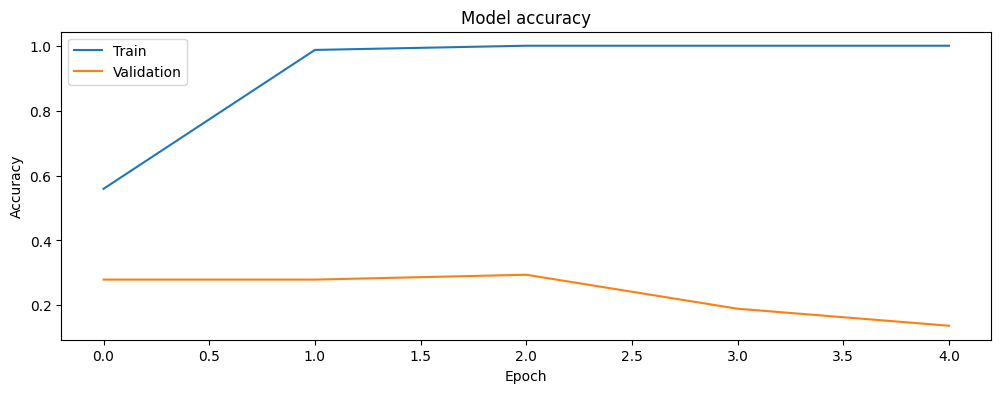

In [109]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

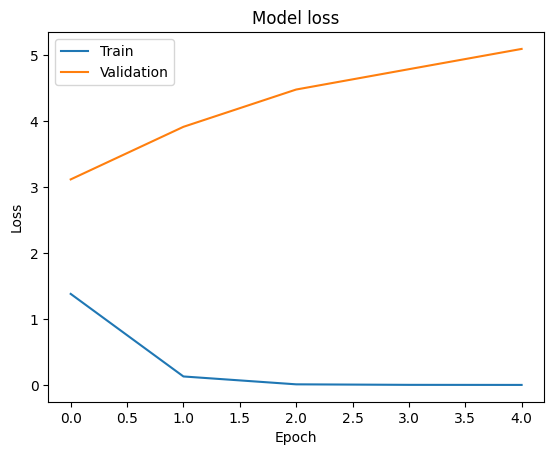

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()